# Clustering t-SNE representations in figure 1c

1. Datasets - the ones shown in Scala et al.'s article, figure 1c. The t-SNE representations of CGE interneurons from Yao et al. and  Scala et al.
3. 2 clusterings for each dataset: each for broad cell families and the smaller cell families
4. Evaluation method: adjusted mutual information, Fowlkes-Mallows

Will use clustering methods in https://scikit-learn.org/stable/modules/clustering.html

In [1]:
import pickle
from collections import namedtuple
import numpy as np
import os.path
from sklearn.cluster import *
from preprocess_figdata import preprocess_figure_data
from plot_fig1c import plot_sidebyside
from misc_tools import le_family_names, ami_and_fmscore

In [2]:
# load Yao et al.'s dataset for the Vip/Lamp5 cells
m1data = pickle.load(open('../../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))["viplamp"]

# load the study results of Scala et al.
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = pickle.load(open('../../data/processed/rnaseq/m1.pickle', 'rb'))

#load transcriptomic type assignment from Scala et al.
ttypes = pickle.load(open('../../data/processed/rnaseq/ttypes.pickle', 'rb'))
subset = np.isin(ttypes['family'], ['Lamp5', 'Vip']) #mask to get vip/lamp5 cell info from m1

# load t-SNE representations of Yao et al.'s Vip/Lamp5 cells
Z = pickle.load(open('../../data/processed/rnaseq/10x-tsne-viplamp.pickle', 'rb')) 

In [3]:
# if the datasets are not preprocessed and put into pickle files yet, do it now
# UMIcnt_path = "../../data/clustering_datasets/viplamp_umi.pickle"
# exintex_path = "../../data/clustering_datasets/viplamp_exint.pickle"

# if (os.path.isfile(UMIcnt_path)==False) and (os.path.isfile(exintex_path)==False):
#     preprocess_figure_data(m1data['counts'], m1data['genes'], m1.exonCounts[subset,:], m1.intronCounts[subset,:], 
#                     m1.genes, m1.exonLengths, m1.intronLengths, UMI_fname=UMIcnt_path, 
#                     exint_fname=exintex_path)

In [4]:
# function for fitting all the scikit-learn models
def fit_all_sklearn(training_data, true_labels, n_clusters, file_path, random_state):
    """
    This function will fit the training data to all clustering methods in this webpage:
    https://scikit-learn.org/stable/modules/clustering.html
    
    The trained models will be saved in the specified file path.
    arguments n_clusters and random_state are for the clustering methods that have these parameters.
    """
    
    model_dict = {} # a dictionary that will contain all trained models
    
    print("Fitting k-means...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(training_data)
    model_dict["k-means"] = kmeans
    pickle.dump(kmeans, open(file_path + "k-means" + ".pickle", 'wb'))

    #print("Fitting affinity propagation...")
    #affinity = AffinityPropagation(random_state=random_state).fit(training_data)
    #model_dict["affinity"] = affinity
    #pickle.dump(affinity, open(file_path + "affinity"+".pickle", 'wb'))

    print("Fitting mean shift...")
    mean_shift = MeanShift().fit(training_data)
    model_dict["mean shift"] = mean_shift
    pickle.dump(mean_shift , open(file_path + "mean_shift" + ".pickle", 'wb'))

    #print("Fitting spectral clustering...")
    #spectral = SpectralClustering(n_clusters=n_clusters).fit(training_data)
    #model_dict["spectral"] = spectral
    #pickle.dump(spectral, open(file_path + "spectral" + ".pickle", 'wb'))

    #print("Fitting agglomerative clustering...")
    #agglo = AgglomerativeClustering(n_clusters=n_clusters).fit(training_data)
    #model_dict["agglomerative"] = agglo
    #pickle.dump(agglo, open(file_path + "agglomerative" + ".pickle", 'wb'))

    print("Fitting DBSCAN...")
    dbscan = DBSCAN().fit(training_data)
    model_dict["dbscan"] = dbscan
    pickle.dump(dbscan, open(file_path + "dbscan"+".pickle", 'wb'))

    print("Fitting OPTICS...")
    optics = OPTICS().fit(training_data)
    model_dict["optics"] = optics
    pickle.dump(optics, open(file_path + "optics" + ".pickle", 'wb'))

    print("Fitting Birch...")
    birch = Birch(n_clusters=n_clusters).fit(training_data)
    model_dict["birch"] = birch
    pickle.dump(birch, open(file_path + "birch" + ".pickle", 'wb'))
    
    return model_dict

In [5]:
def print_results(model_dict,true_labels): 
    """
    This function is for getting and displaying the prediction results.
    """
    pred_dict = {} # dictionary to store the predictions
    score_dict = {} # dictionary to store the evaluation scores
    
    # print the adjusted mutual information and Fowlkes-Mallows score
    for  model_name, model in model_dict.items():
        scores={}
        print("-------------------------------"+model_name+"-------------------------------")
        pred = model.labels_
        scores["ami"],  scores["fms"] =  ami_and_fmscore(true_labels, pred) 

        pred_dict[model_name] = pred
        score_dict[model_name] = scores
    
    # plot clustering results with figure 1c
    for  model_name, pred  in pred_dict.items():
        plot_sidebyside(pred, training_data, m1data, title=model_name)
    
    return pred_dict, score_dict

## Broad cell families

In [6]:
random_state = 0 # setting random state for models 
save = True # setting this too true will train and save the models, else it will load the models saved last time

### Yao et al.'s cells

Yao et al.'s data has 15,511 cells from three broad cell families, Vip, Lamp5, and Sncg. They are all expressed in 2-dimensional t-SNE representations.

In [7]:
n_clusters = 3 # the number of broad cell families is 3
training_data = Z
file_path = "./models/t-SNE/Yao/"

In [8]:
# create broad cell family labels because Yao et al.'s data doesn't come with one
yao_family_names, yao_family_codes = le_family_names(m1data)

Family_labels:
Lamp5: [0]
Sncg: [1]
Vip: [2]


In [9]:
if save == True:
    model_dict_yao = fit_all_sklearn(training_data=Z, true_labels=yao_family_codes, n_clusters=n_clusters, 
                                 file_path=file_path, random_state=random_state)
else:
    model_dict_yao={}
    model_dict_yao["k-means"] = pickle.load(open(file_path + "k-means" + ".pickle", 'rb'))
    #model_dict_yao["affinity"] = pickle.load(open(file_path + "affinity"+".pickle", 'rb'))
    model_dict_yao["mean shift"] = pickle.load(open(file_path + "mean_shift" + ".pickle", 'rb'))
    #model_dict_yao["spectral"] = pickle.load(open(file_path + "spectral" + ".pickle", 'rb'))
    #model_dict_yao["agglo"] = pickle.load(open(file_path + "agglomerative" + ".pickle", 'rb'))
    model_dict_yao["dbscan"] = pickle.load(open(file_path + "dbscan"+".pickle", 'rb'))
    model_dict_yao["optics"] = pickle.load(open(file_path + "optics" + ".pickle", 'rb'))
    model_dict_yao["birch"] = pickle.load(open(file_path + "birch" + ".pickle", 'rb'))

Fitting k-means...
Fitting mean shift...
Fitting DBSCAN...
Fitting OPTICS...
Fitting Birch...


-------------------------------k-means-------------------------------
Adjusted Mutual Info: 0.4434050321834575
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.656219406649552
(0: bad, 1: perfect)

-------------------------------mean shift-------------------------------
Adjusted Mutual Info: 0.4744960189181844
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.7442733871511906
(0: bad, 1: perfect)

-------------------------------dbscan-------------------------------
Adjusted Mutual Info: 0.1621440437896786
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.39058980536946397
(0: bad, 1: perfect)

-------------------------------optics-------------------------------
Adjusted Mutual Info: 0.16467844379437271
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.2991923559874163
(0: bad, 1: perfect)

-------------------------------birch-------------------------------
Adjusted Mutual Info: 0.5242290854653756
(0: bad, 1: perfect)

Fowlkes-Mallows Score:  0.7181350833284096
(0: bad, 1: perfect)



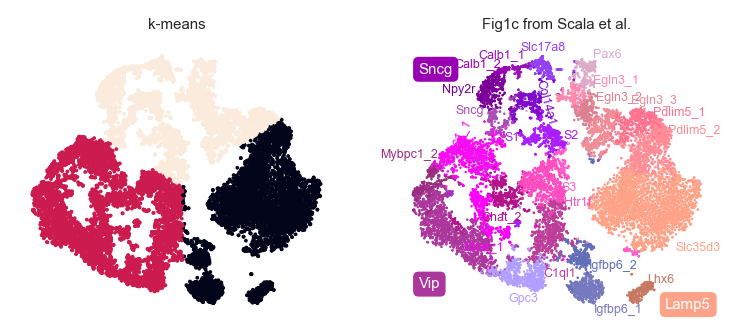

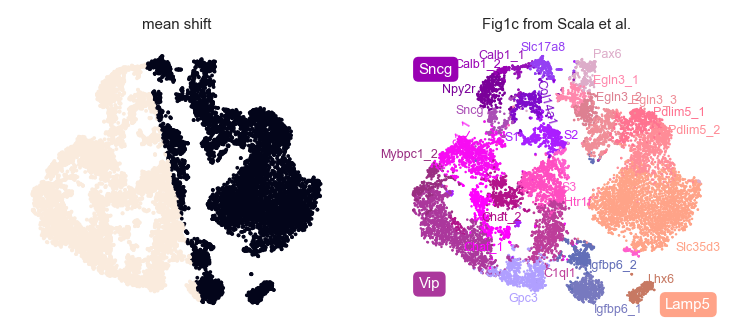

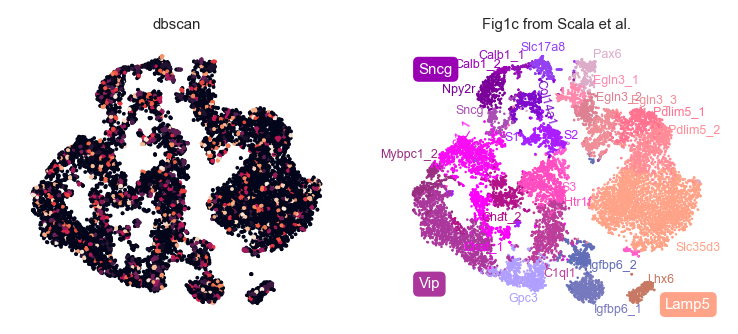

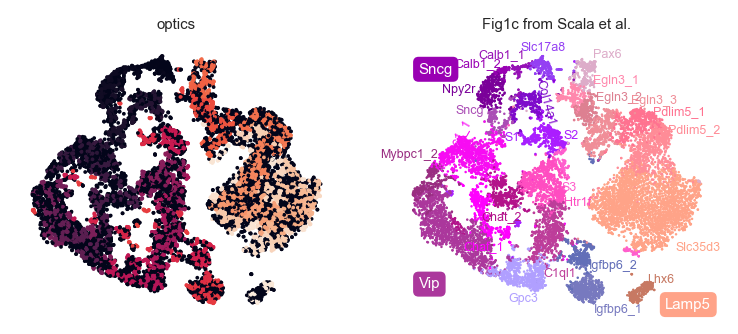

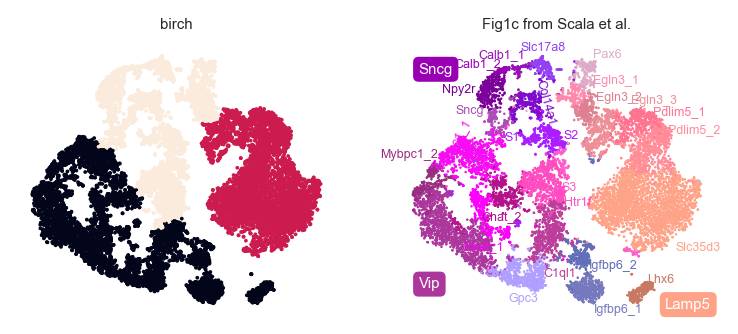

In [10]:
pred_yao, score_yao = print_results(model_dict,true_labels=yao_family_codes)

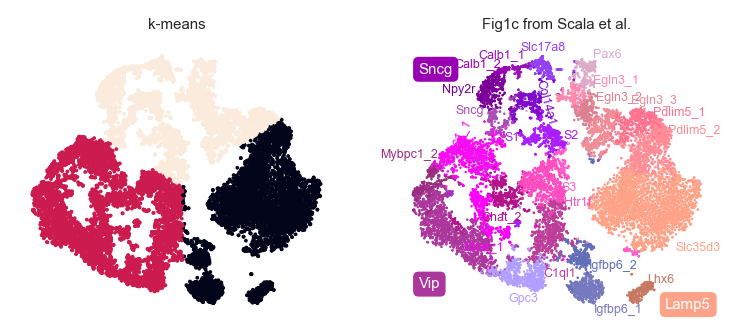

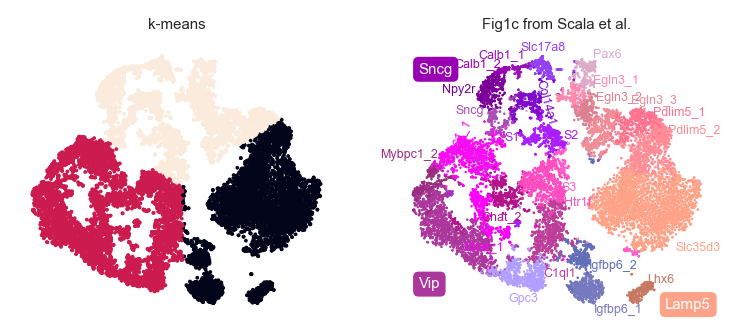

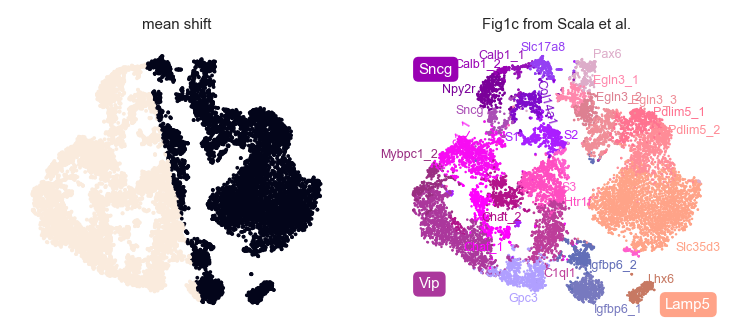

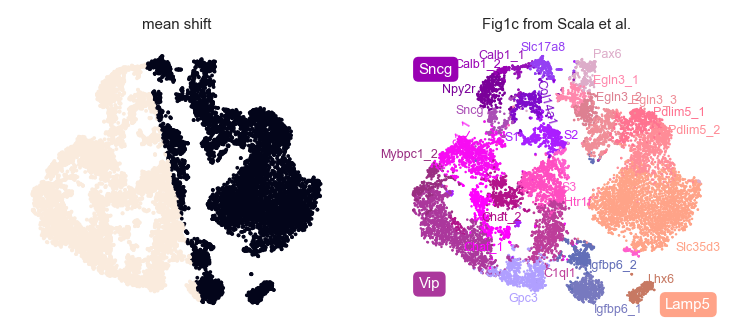

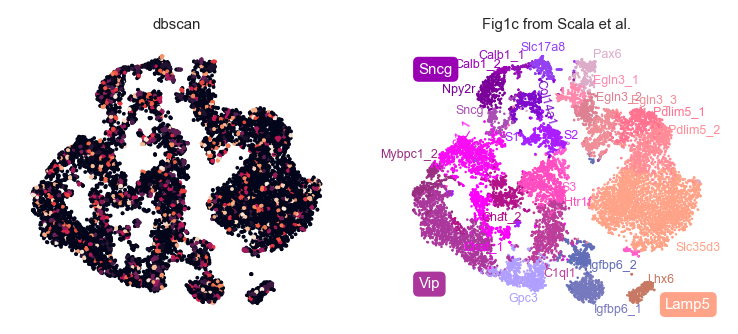

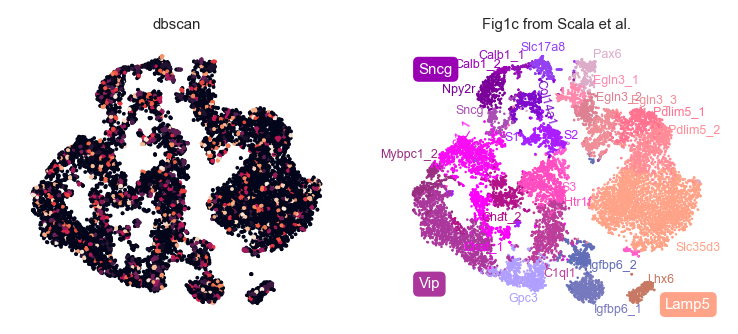

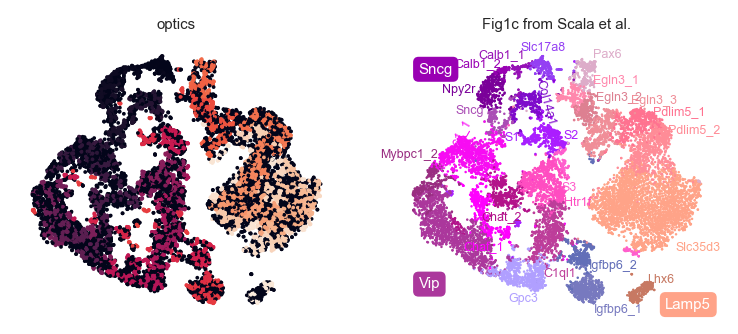

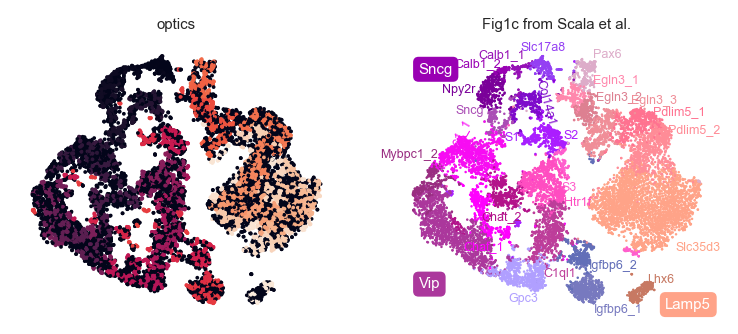

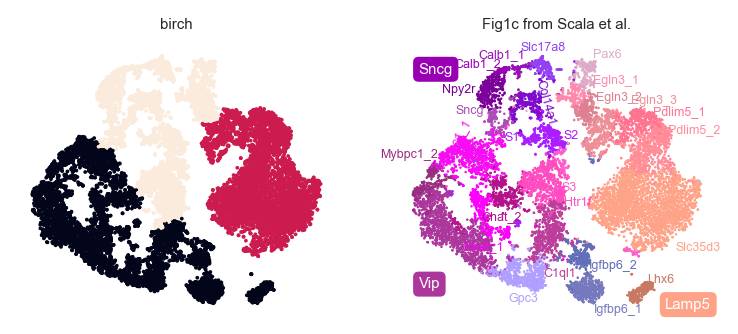

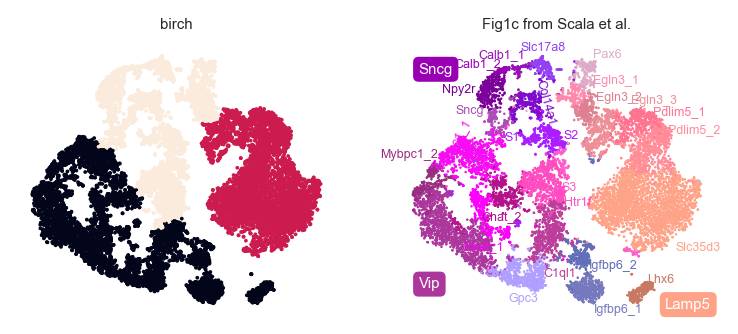

In [24]:
# plot clustering results with figure 1c
for  model_name, pred  in pred_yao.items():
    plot_sidebyside(pred, training_data, m1data, title=model_name)